Developing a Flower classifier using transfer learning. Resnet34 is being used as the backbone of the model. The library from the course [Fast.ai](https://github.com/fastai/fastai) is being used here. The Data is from Kaggle's flower recognition dataset. 


Data:  (https://www.kaggle.com/alxmamaev/flowers-recognition)

In [0]:
from fastai.vision import *
from fastai import *
from fastai.metrics import error_rate
from fastai.script import *
from fastai.distributed import *

In [0]:
!pip show fastai 

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'deep_learning_data/'

path = base_dir + 'flowers/'

Read The data using ImageDataBunch class from fastai library

In [0]:
np.random.seed(42)
tfms = get_transforms(do_flip=False)
data = ImageDataBunch.from_folder(path, valid_pct=0.2, bs = 16,
        ds_tfms=get_transforms(), size=200, num_workers=4).normalize(imagenet_stats)


Print the name of the classes of flower in data

In [5]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'], 5, 3459, 864)

Show some images



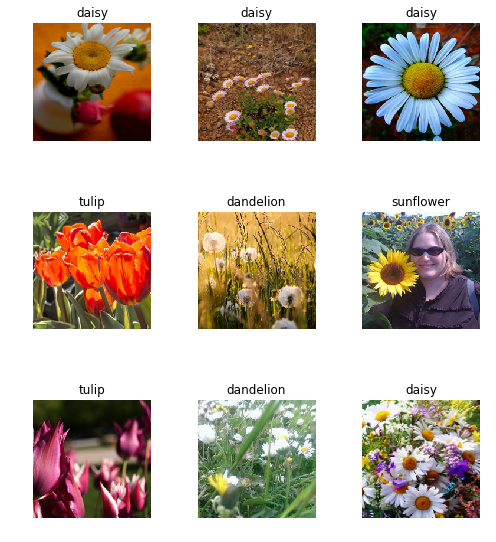

In [6]:
data.show_batch(rows= 3,  figsize=(7,8))

Creat the learner object


In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

Let's use the lr_find in fastai to find a good learning rate for model

Fit the resnet model for 4 epochs using thenew model . This way we only fit the later layers of the model.

In [21]:
learn.fit_one_cycle(4)
learn.save('stage-1')

epoch,train_loss,valid_loss,error_rate,time
0,0.681797,0.336039,0.119213,00:44
1,0.522134,0.297444,0.108796,00:45
2,0.461938,0.240130,0.094907,00:45
3,0.348022,0.237894,0.087963,00:45


We have validation loss of 0.23 and error rate of 0.08 which means the model is performing well. Also the validation loss is not higher than training loss so we are not overfitting. In fact the model has a bit of space to improve and get better.

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


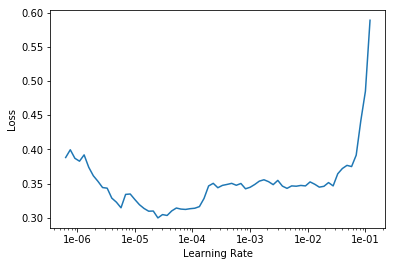

In [22]:
learn.lr_find()
learn.recorder.plot()

Let's see if fine tuning the whole model will help us better.

In [31]:
learn.unfreeze()
learn.fit_one_cycle(1)


epoch,train_loss,valid_loss,error_rate,time
0,0.566535,0.270188,0.082176,00:47


unfreezing helped the model slightly. So lets go back to the previous stage of the model and find a range of learning rates

In [0]:
learn.load('stage-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


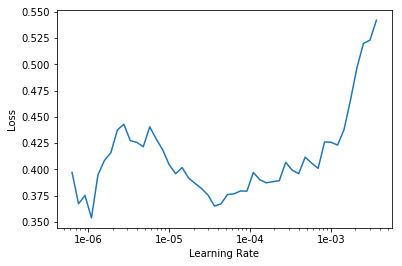

In [39]:
learn.lr_find()
learn.recorder.plot()

In order to choose a good learning rate: start from where the loss is suddenly increasing and choose a learning rate 10 times smaller (so 2e-4 here). Since we want to unfreeze the model and want to train the earlier layers of the model as well, we have to give a range of learning rates to the model. So we choose 2e-4/0.01 where 0.01 is the first lr that we used above. 

In [40]:
learn.unfreeze()
learn.fit_one_cycle(1, max_lr = slice(2e-6,2e-4))


epoch,train_loss,valid_loss,error_rate,time
0,0.327002,0.221447,0.070602,00:47


The error rate and validation loss decreased slightly so we are in good direction and not doing overfiting



In [0]:
learn.save('stage-2')

No let's increase the number of epochs and see if we can increase the perfomance more


In [42]:
learn.load('stage-1')
learn.unfreeze()
learn.fit_one_cycle(2, max_lr = slice(2e-6,2e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.330788,0.214897,0.074074,00:47
1,0.271317,0.201151,0.067130,00:46


training for an additional epoch increased the prediction performance!

Let's export the model

In [0]:
learn.export()

Now let's interpret the performance of the model. We want to see which location of the image had the most effect on the prediction made by model. We want to understand if the model is performing reasonable

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

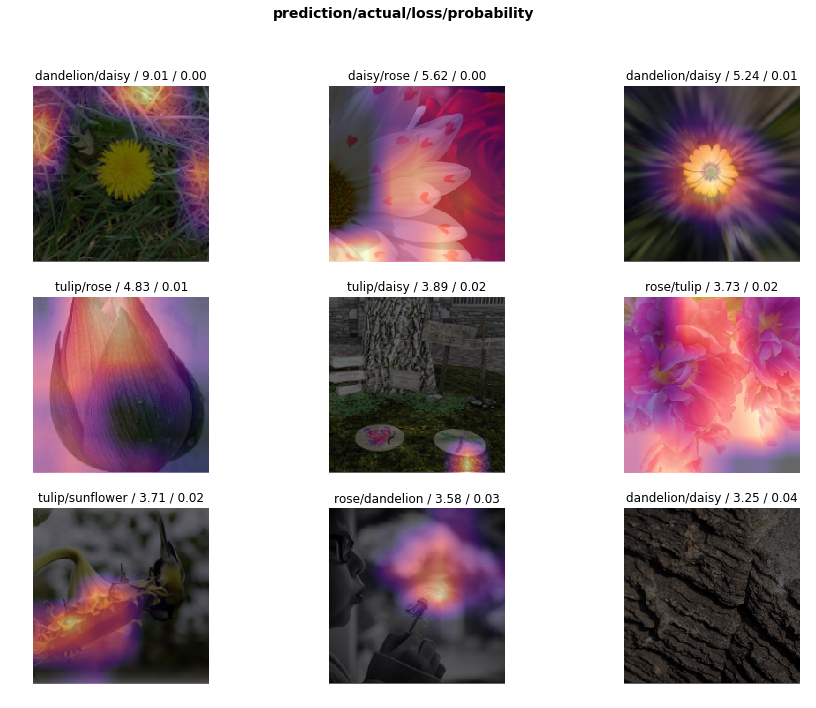

In [45]:
losses, idx = interp.top_losses()
interp.plot_top_losses(9, figsize=(15,11))

In the above we see the images that had worst clssification with top losses. You can see that even in images that are scens of different locations (the middle picture) the model is able to capture where the flower is but it has made a poor job of predicting the type of the flower.

You can also see that since we did not do a good job of data cleaning, we have a wrong image categoized as daisy flower (lower right picture). This hints that we need to clean in our data to its best before model development.

We can use these missclassified images to update our model and help it get better at prediction of harder samples

Now to predict a class for a sample image of interest:

In [0]:
img = open_image(path+"rose/13231224664_4af5293a37.jpg")
learn.predict(img)

(Category rose,
 tensor(2),
 tensor([5.5604e-05, 5.4203e-05, 9.9471e-01, 6.4143e-04, 4.5359e-03]))